In [14]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add("XLSX")
Pkg.add("CSV")


  Activating project at `~/Desktop/BEE 4750/BEE4750FinalProject-1`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`
   Resolving package versions...
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Project.toml`
  No Changes to `~/Desktop/BEE 4750/BEE4750FinalProject-1/Manifest.toml`


In [15]:
using JuMP
using HiGHS
using DataFrames
using GraphRecipes
using Plots
using Measures
using MarkdownTables
using XLSX
using CSV

Load Data for all buildings

In [31]:
# Read the CSV file into a DataFrame
df = CSV.read("CascadillaHall.csv", DataFrame)
date = df."Date"[1:366]
casc_steam = df."Steam (lbs/hr)"[1:366]
casc_electric = df."Electric (kW)"[1:366]

df = CSV.read("HuShihHall.csv", DataFrame)
hushih_chilled_water = df."Chilled Water (tons)"[1:366]
hushih_hot_water = df."Hot Water (kBTU/hr)"[1:366]
hushih_electric = df."Electric (kW)"[1:366]

df = CSV.read("UrisLibrary.csv", DataFrame)
uris_chilled_water = df."Chilled Water (tons)"[1:366]
uris_electric = df."Electric (kW)"[1:366]
uris_steam = df."Steam (lbs/hr)"[1:366]

df = CSV.read("UrisLibrary.csv", DataFrame)
uris_chilled_water = df."Chilled Water (tons)"[1:366]
uris_electric = df."Electric (kW)"[1:366]
uris_steam = df."Steam (lbs/hr)"[1:366]

df = CSV.read("MannLibrary.csv", DataFrame)
mann_chilled_water = df."Chilled Water (tons)"[1:366]
mann_electric = df."Electric (kW)"[1:366]
mann_steam = df."Steam (lbs/hr)"[1:366]

df = CSV.read("BakerLab.csv", DataFrame)
baker_chilled_water = df."Chilled Water (tons)"[1:366]
baker_electric = df."Electric (kW)"[1:366]
baker_steam = df."Steam (lbs/hr)"[1:366]

df = CSV.read("PSB.csv", DataFrame)
psb_chilled_water = df."Chilled Water (tons)"[1:366]
psb_electric = df."Electric (kW)"[1:366]
psb_steam = df."Steam (lbs/hr)"[1:366]



366-element Vector{Union{Missing, Float64}}:
 2079.7280625
 1909.234020833
 2041.344375
 2451.040375
 2452.600385416
 2104.941322916
 2016.493541666
 1866.85825
 1443.338795833
 1723.01178125
    ⋮
 2529.984645833
 2461.53715625
 2864.000625
 2633.734729166
 1560.407110416
 1373.702002083
 1471.28446875
 1586.221302083
 1671.9649375

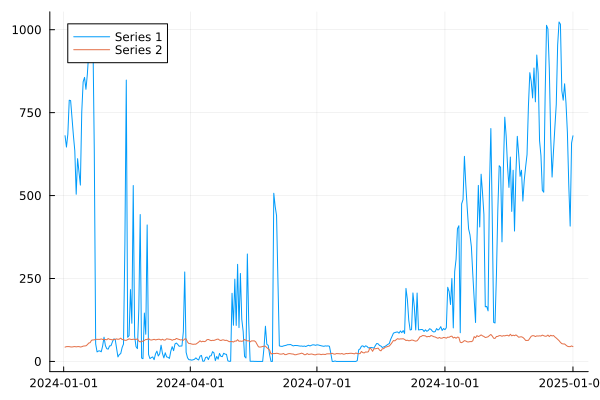

In [18]:
# Cascadilla plots
p = plot(date, casc_steam, label="Series 1")
plot!(p, date, casc_electric, label="Series 2")
display(p)

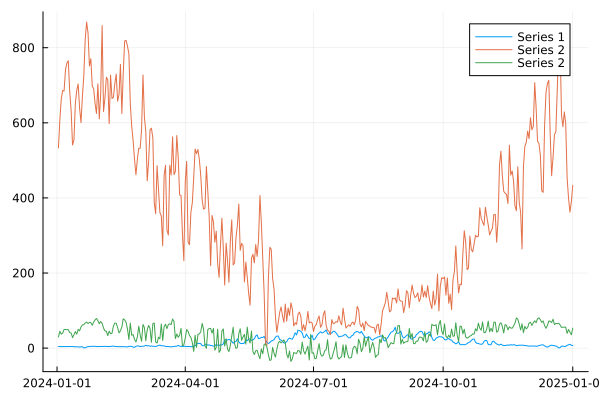

In [19]:
# Hu Shih Plots
p = plot(date, hushih_chilled_water, label="Series 1")
plot!(p, date, hushih_hot_water, label="Series 2")
plot!(p, date, hushih_electric, label="Series 2")
display(p)

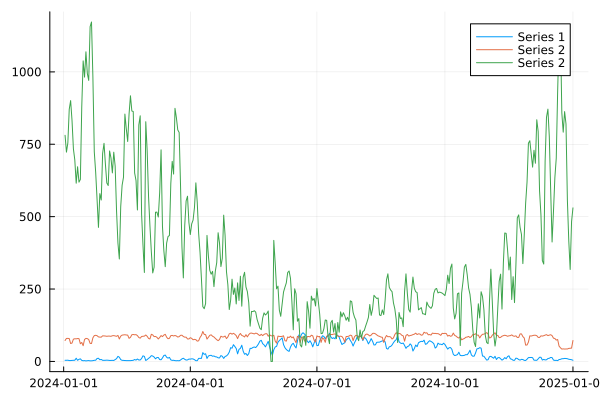

In [20]:
# Uris Library Plots
p = plot(date, uris_chilled_water, label="Series 1")
plot!(p, date, uris_electric, label="Series 2")
plot!(p, date, uris_steam, label="Series 2")
display(p)

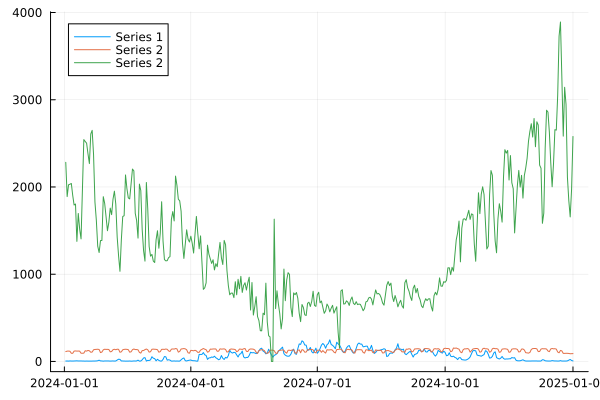

In [22]:
# Mann Library Plots
p = plot(date, mann_chilled_water, label="Series 1")
plot!(p, date, mann_electric, label="Series 2")
plot!(p, date, mann_steam, label="Series 2")
display(p)

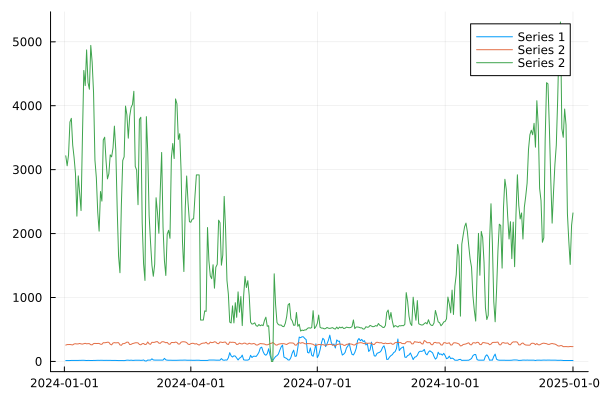

In [26]:
# Baker Lab Plots
p = plot(date, baker_chilled_water, label="Series 1")
plot!(p, date, baker_electric, label="Series 2")
plot!(p, date, baker_steam, label="Series 2")
display(p)

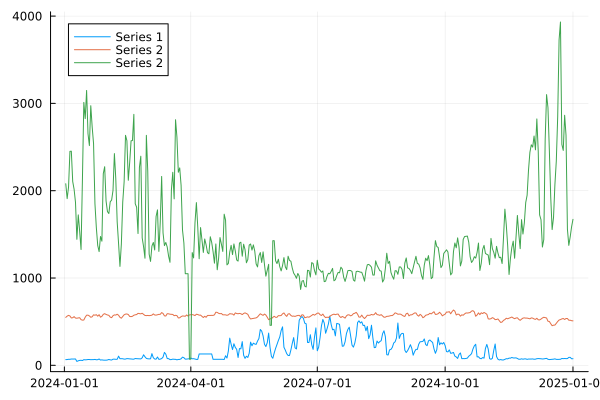

In [32]:
# PSB Plots
p = plot(date, psb_chilled_water, label="Series 1")
plot!(p, date, psb_electric, label="Series 2")
plot!(p, date, psb_steam, label="Series 2")
display(p)